In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math

MAX_DATE = dt.date(dt.strptime('5555-01-01', '%Y-%m-%d'))

#Чтение исходных данных
df_metro = pd.read_csv('data/metro.csv', encoding='UTF-8', sep=';')
df_trans = pd.read_csv('data/transitions.csv', encoding='UTF-8', sep=';')

df_trains = pd.read_csv('data/stations.csv', encoding='UTF-8', sep=';')

df_stats = pd.concat([df_metro, df_trains], ignore_index=True)

#Нумерация станций
df_stats.insert(0, "row_number", df_stats.index + 1)
df_stats.insert(1, "graph_number", df_stats.index + 1)

df_trans_row = df_trans.merge(df_stats, how='inner', left_on=["src_line","src_number"], right_on=["line","number"]).merge(df_stats, how='inner', left_on=["dest_line","dest_number"], right_on=["line","number"])[['type','line_x','row_number_x','line_y','row_number_y']]

In [8]:
def build_graph(stations, transitions):
    graph = nx.Graph()
    graph.add_nodes_from(stations)
    graph.add_edges_from(transitions)
    return graph


def build_network_l(df_stations, df_transitions, date_pos=MAX_DATE):  
    #Сбор станций, существовавших на момент date_pos
    df_pos_stations = pd.DataFrame(columns=df_stations.columns)
    for i, stat in df_stations.iterrows():
        start_date = dt.date(dt.strptime(stat.open_date, '%d.%m.%Y'))
        end_date = dt.date(dt.strptime(stat.close_date, '%d.%m.%Y'))
        if start_date <= date_pos and end_date >= date_pos:
            df_pos_stations = df_pos_stations.append(stat, ignore_index=True)

    #Сбор переходов, существовавших на момент date_pos        
    df_pos_transitions = pd.DataFrame(columns=df_trans_row.columns)
    for i, trans in df_trans_row.iterrows():
        src_rn = trans.row_number_x
        dest_rn = trans.row_number_y
        start_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["close_date"].values[0], '%d.%m.%Y'))
        start_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["close_date"].values[0], '%d.%m.%Y'))
        if start_date1 <= date_pos and end_date1 >= date_pos and start_date2 <= date_pos and end_date2 >= date_pos:
            df_pos_transitions = df_pos_transitions.append(trans, ignore_index=True)
        
    transitions_list = df_pos_transitions[["row_number_x","row_number_y"]].values.tolist()
    #Совмещение станций
    for trans in transitions_list:
        src_stat = df_pos_stations.loc[(df_pos_stations.row_number == trans[0]),"graph_number"].values[0]
        df_pos_stations.loc[(df_pos_stations.row_number == trans[1]),"graph_number"] = src_stat

    stations_list = df_pos_stations["graph_number"].values.tolist()
    circle_line_list = pd.unique(df_pos_stations.loc[df_pos_stations.line_shape == 'circle']["line"].values)

    connections_list = []
    #Сбор связей в рамках одного ответвления
    for i in range(df_pos_stations["row_number"].count() - 1):
        if df_pos_stations.iloc[i].line == df_pos_stations.iloc[i + 1].line:
            connections_list.append([stations_list[i], stations_list[i + 1]])
    #Сбор связей между ответвлениями
    line_list = list(pd.unique(df_pos_stations["line"].values))
    for line in line_list:
        dest_src = df_pos_stations.loc[df_pos_stations.line == line]["graph_number"].values[0]
        if ':' in stat.line:
            subline = line[:line.rfind(':')]
            if len(df_pos_stations.loc[df_pos_stations.line == subline]["graph_number"].values) > 0 and dest_src != df_pos_stations.loc[df_pos_stations.line == subline]["graph_number"].values[-1]:
                src_stat = df_pos_stations.loc[df_pos_stations.line == subline]["graph_number"].values[-1]
                connections_list.append([src_stat, dest_src])
    #Сбор связей, замыкающих кольца
    for line in circle_line_list:
        connections_list.append([df_pos_stations.loc[df_pos_stations['line'] == line]["graph_number"].values[0], df_pos_stations.loc[df_pos_stations['line'] == line]["graph_number"].values[-1]])

    stations_list = pd.unique(stations_list)
    
    return build_graph(stations_list, connections_list), df_pos_stations


def build_network_p(df_stations, df_transitions, date_pos=MAX_DATE):
    #Сбор станций, существовавших на момент date_pos
    df_pos_stations = pd.DataFrame(columns=df_stations.columns)
    for i, stat in df_stations.iterrows():
        start_date = dt.date(dt.strptime(stat.open_date, '%d.%m.%Y'))
        end_date = dt.date(dt.strptime(stat.close_date, '%d.%m.%Y'))
        if start_date <= date_pos and end_date >= date_pos:
            df_pos_stations = df_pos_stations.append(stat, ignore_index=True)

    #Сбор переходов, существовавших на момент date_pos        
    df_pos_transitions = pd.DataFrame(columns=df_trans_row.columns)
    for i, trans in df_trans_row.iterrows():
        src_rn = trans.row_number_x
        dest_rn = trans.row_number_y
        start_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["close_date"].values[0], '%d.%m.%Y'))
        start_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["close_date"].values[0], '%d.%m.%Y'))
        if start_date1 <= date_pos and end_date1 >= date_pos and start_date2 <= date_pos and end_date2 >= date_pos:
            df_pos_transitions = df_pos_transitions.append(trans, ignore_index=True)

    transitions_list = df_pos_transitions[["row_number_x","row_number_y"]].values.tolist()
    #Совмещение станций
    for trans in transitions_list:
        src_stat = df_pos_stations.loc[(df_pos_stations.row_number == trans[0]),"graph_number"].values[0]
        df_pos_stations.loc[(df_pos_stations.row_number == trans[1]),"graph_number"] = src_stat

    stations_list = df_pos_stations["graph_number"].values.tolist()

    #Типизация ветвлений: main - конец, side - разветвляющаяся
    line_type_list = []
    line_list = list(pd.unique(df_pos_stations["line"].values))
    for line in line_list:
        if ':' in line:
            subline = line[:line.rfind(':')]
            if subline in line_list:
                line_type_list[line_list.index(subline)][1] = 'side'
        line_type_list.append([line, 'main'])

    lines = []
    for line in line_type_list:
        if line[1] == 'main':
            lines.append(line[0])

    connections_list = []
    for line in lines:
        line_list = [line] #список совместных направлений
        while ':' in line:
            line = line[:line.rfind(':')]
            line_list.append(line)

        line_stations = list(pd.unique(df_pos_stations.loc[df_pos_stations['line'].isin(line_list)]["graph_number"].values)) #список станций со всех совместных направлений
        for i in line_stations[:-1]:
            for j in line_stations[line_stations.index(i):]:
                if i != j:
                    connections_list.append([i, j])

    stations_list = pd.unique(stations_list)

    return build_graph(stations_list, connections_list), df_pos_stations


def build_network_c(df_stations, df_transitions, date_pos=MAX_DATE):
    #Сбор станций, существовавших на момент date_pos
    df_pos_stations = pd.DataFrame(columns=df_stations.columns)
    for i, stat in df_stations.iterrows():
        start_date = dt.date(dt.strptime(stat.open_date, '%d.%m.%Y'))
        end_date = dt.date(dt.strptime(stat.close_date, '%d.%m.%Y'))
        if start_date <= date_pos and end_date >= date_pos:
            df_pos_stations = df_pos_stations.append(stat, ignore_index=True)

    #Сбор переходов, существовавших на момент date_pos        
    df_pos_transitions = pd.DataFrame(columns=df_trans_row.columns)
    for i, trans in df_trans_row.iterrows():
        src_rn = trans.row_number_x
        dest_rn = trans.row_number_y
        start_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date1 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == src_rn]["close_date"].values[0], '%d.%m.%Y'))
        start_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["open_date"].values[0], '%d.%m.%Y'))
        end_date2 = dt.date(dt.strptime(df_stations.loc[df_stations["row_number"] == dest_rn]["close_date"].values[0], '%d.%m.%Y'))
        if start_date1 <= date_pos and end_date1 >= date_pos and start_date2 <= date_pos and end_date2 >= date_pos:
            df_pos_transitions = df_pos_transitions.append(trans, ignore_index=True)

    #Создание соответсвия ветви и ответвления
    line_list, subline_list = [], []
    for line in pd.unique(df_pos_stations["line"].values):
        subline = line
        while ':' in subline:
            subline = subline[:subline.rfind(':')]
        line_list.append(line)
        subline_list.append(subline)

    #Отбор ветвей из переходов
    transitions_list = df_pos_transitions[df_pos_transitions['type'] != ('metro', 'trains')][['line_x','line_y']].drop_duplicates().values.tolist()
    #Ренейминг ответвлений на ветви
    for i in range(len(transitions_list)):
        if transitions_list[i][0] in line_list:
            transitions_list[i][0] = subline_list[line_list.index(transitions_list[i][0])]
        if transitions_list[i][1] in line_list:
            transitions_list[i][1] = subline_list[line_list.index(transitions_list[i][1])]

    subline_list = list(set(subline_list))
    transitions_list = list(set([tuple(trans) for trans in transitions_list]))
    
    return build_graph(subline_list, transitions_list), df_pos_stations

In [9]:
date_pos = dt.date(dt.strptime('2022-01-01', '%Y-%m-%d'))

In [10]:
#Создание графов
l_network22, df_l_stations22 = build_network_l(df_stats, df_trans_row, date_pos)
p_network22, df_p_stations22 = build_network_p(df_stats, df_trans_row, date_pos)
c_network22, df_c_stations22 = build_network_c(df_stats, df_trans_row, date_pos)

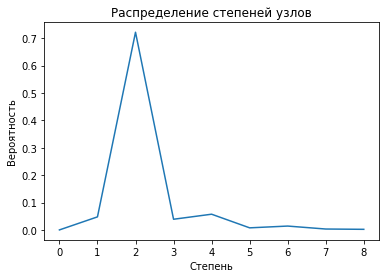

In [11]:
plt.plot([i / nx.number_of_edges(l_network22) for i in nx.degree_histogram(l_network22)])
plt.title('Распределение степеней узлов')
plt.xlabel('Степень')
plt.ylabel('Вероятность')
plt.savefig('./results/degree_distribution.png')
plt.show()

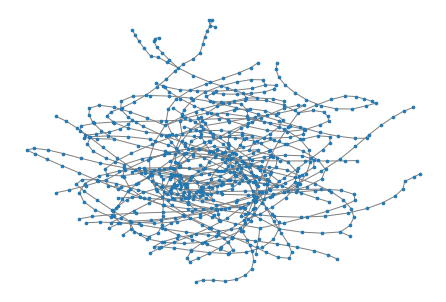

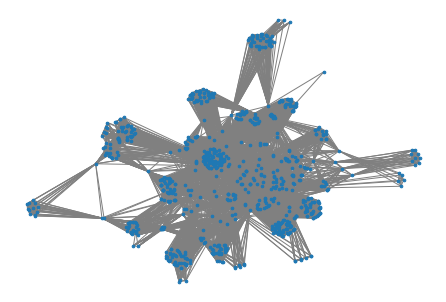

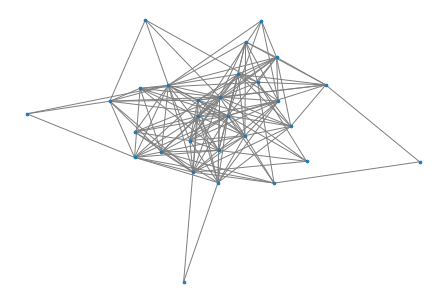

In [12]:
#Рисование графов
nx.draw(l_network22, width=1, node_size=7, edge_color='gray')
plt.show()
nx.draw(p_network22, width=1, node_size=7, edge_color='gray')
plt.show()
nx.draw(c_network22, width=1, node_size=7, edge_color='gray')
plt.show()

In [13]:
#Число узлов
def nodes_number(graph):
    return nx.number_of_nodes(graph)

#Число связей
def edges_number(graph):
    return nx.number_of_edges(graph)

#Средняя кластеризация
def clustering(graph):
    return nx.average_clustering(graph)

#Средняя кратчайшая длина пути
def closeness(graph):
    missed_count = 0
    closeness_list = []
    for i in list(nx.closeness_centrality(graph).values()):
        if i != 0:
            closeness_list.append(1 / i)
        else:
            missed_count += 1
    return sum(closeness_list) / (nx.number_of_nodes(graph) - missed_count)

#Ассортативность
def assortativity(graph):
    return nx.degree_pearson_correlation_coefficient(graph)

In [14]:
#Общая статика
df_out = pd.DataFrame([['l_network', nodes_number(l_network22), edges_number(l_network22), clustering(l_network22), closeness(l_network22), assortativity(l_network22)], 
                       ['p_network', nodes_number(p_network22), edges_number(p_network22), clustering(p_network22), closeness(p_network22), assortativity(p_network22)], 
                       ['c_network', nodes_number(c_network22), edges_number(c_network22), clustering(c_network22), closeness(c_network22), assortativity(c_network22)]],
                    columns=['Сеть', 'Число узлов', 'Число связей', 'Средняя кластеризация', 'Cредняя кратчайшая длина пути', 'Ассортативность'])

df_out.to_excel('./results.xlsx')
df_out

,Сеть,Число узлов,Число связей,Средняя кластеризация,Cредняя кратчайшая длина пути,Ассортативность
0,l_network,825,924,0.011108,31.781030,0.332356
1,p_network,825,21366,0.902691,2.453919,0.347179
2,c_network,29,168,0.548969,1.687192,-0.119684


In [20]:
#Вычисление ассортативности 1940-2022
df_assortativity = pd.DataFrame(columns=['Год', 'L-сеть', 'P-сеть', 'C-сеть'])
for year in range(1940, 2022):
    date_pos = dt.date(dt.strptime(f'{year + 1}-01-01', '%Y-%m-%d'))
    l_network, df_l_stations_pos = build_network_l(df_stats, df_trans_row, date_pos)
    p_network, df_p_stations_pos = build_network_p(df_stats, df_trans_row, date_pos)
    c_network, df_c_stations_pos = build_network_c(df_stats, df_trans_row, date_pos)
    
    pd_row = pd.DataFrame([[date_pos
                            , assortativity(l_network)
                            , assortativity(p_network)
                            , assortativity(c_network)]],
                    columns=['Год', 'L-сеть', 'P-сеть', 'C-сеть'])
    df_assortativity = df_assortativity.append(pd_row)
df_assortativity = df_assortativity.set_index("Год")
df_assortativity.to_excel('./results/assortativity.xlsx')
df_assortativity.head()

,L-сеть,P-сеть,C-сеть
Год,,,
1941-01-01,-0.012768,0.088543,0.174425
1942-01-01,-0.012457,0.103730,0.174425
1943-01-01,-0.099854,0.120702,0.174425
1944-01-01,-0.094245,0.450757,0.027702
1945-01-01,-0.025963,0.444966,0.039347


In [15]:
#Загрузка резльтатов ассортативности 1940-2022
df_assortativity = pd.read_excel('./results/assortativity.xlsx')
df_assortativity = df_assortativity.set_index("Год")
df_assortativity

,L-сеть,P-сеть,C-сеть
Год,,,
1941-01-01,-0.012768,0.088543,0.174425
1942-01-01,-0.012457,0.103730,0.174425
1943-01-01,-0.099854,0.120702,0.174425
1944-01-01,-0.094245,0.450757,0.027702
1945-01-01,-0.025963,0.444966,0.039347
...,...,...,...
2018-01-01,0.324025,0.420383,-0.051742
2019-01-01,0.338718,0.419179,-0.053404
2020-01-01,0.347636,0.356046,-0.084771


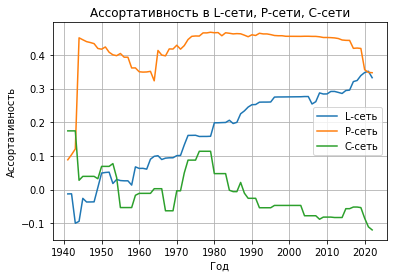

In [75]:
#Динамика ассортативности
plt.plot(df_assortativity["L-сеть"], label='L-сеть')
plt.plot(df_assortativity["P-сеть"], label='P-сеть')
plt.plot(df_assortativity["C-сеть"], label='C-сеть')
plt.title('Ассортативность в L-сети, P-сети, C-сети')
plt.xlabel('Год')
plt.ylabel('Ассортативность')
plt.legend()
plt.savefig('./results/assortativity.png')
plt.grid()
plt.show()

In [38]:
#Статика на 2022 по степеням, нагрузке и близости
date_pos = dt.date(dt.strptime('2022-01-01', '%Y-%m-%d'))
#Создание графов
l_network22, df_l_stations22 = build_network_l(df_stats, df_trans_row, date_pos)
p_network22, df_p_stations22 = build_network_p(df_stats, df_trans_row, date_pos)
c_network22, df_c_stations22 = build_network_c(df_stats, df_trans_row, date_pos)

df_stations_stat = pd.DataFrame(columns=['Сеть', 'Номер', 'Линия', 'Станция', 'Степень', 'Нагрузка', 'Близость'])

bc = nx.betweenness_centrality(l_network22)
cc = nx.closeness_centrality(l_network22)
for node, degree in nx.degree(l_network22):
    df_node_stations = df_l_stations22.loc[df_l_stations22['graph_number'] == node]
    for i in range(len(df_node_stations)):
        pd_row = pd.DataFrame([['L-сеть'
                                , df_l_stations22.loc[df_l_stations22['graph_number'] == node]['row_number'].values[i]
                                , df_l_stations22.loc[df_l_stations22['graph_number'] == node]['line'].values[i]
                                , df_l_stations22.loc[df_l_stations22['graph_number'] == node]['station'].values[i]
                                , degree
                                , bc[node]
                                , cc[node]]],
                        columns=['Сеть', 'Номер', 'Линия', 'Станция', 'Степень', 'Нагрузка', 'Близость'])
        df_stations_stat = df_stations_stat.append(pd_row)
bc = nx.betweenness_centrality(p_network22)
cc = nx.closeness_centrality(p_network22)
for node, degree in nx.degree(p_network22):
    df_node_stations = df_p_stations22.loc[df_p_stations22['graph_number'] == node]
    for i in range(len(df_node_stations)):
        pd_row = pd.DataFrame([['P-сеть'
                                , df_p_stations22.loc[df_p_stations22['graph_number'] == node]['row_number'].values[i]
                                , df_p_stations22.loc[df_p_stations22['graph_number'] == node]['line'].values[i]
                                , df_p_stations22.loc[df_p_stations22['graph_number'] == node]['station'].values[i]
                                , degree
                                , bc[node]
                                , cc[node]]],
                        columns=['Сеть', 'Номер', 'Линия', 'Станция', 'Степень', 'Нагрузка', 'Близость'])
        df_stations_stat = df_stations_stat.append(pd_row)
    
df_stations_stat.to_excel('./results/stations_stat.xlsx')
df_stations_stat.head()

,Сеть,Номер,Линия,Станция,Степень,Нагрузка,Близость
0,L-сеть,1,Сокольническая,Бульвар Рокоссовского,2,0.006448,0.042067
0,L-сеть,259,Московское центральное кольцо,Бульвар Рокоссовского,2,0.006448,0.042067
0,L-сеть,2,Сокольническая,Черкизовская,3,0.007989,0.042741
0,L-сеть,260,Московское центральное кольцо,Локомотив,3,0.007989,0.042741
0,L-сеть,3,Сокольническая,Преображенская площадь,2,0.001109,0.042841


In [27]:
#Диманимика по нагрузке 
stations_demo = {(149, 767, 379, 203): 'Площадь Ильича',
                 (65, 93, 202, 326, 396, 766): 'Курская',
                 (246, 265, 398): 'Нижегородская',
                 (6, 94, 325, 460, 765, 801, 997): 'Комсомольская',
                 (492,): 'Куровская',
                 (61, 76, 77, 80, 99, 582): 'Киевская',
                 (144, 250, 469): 'Лермонтовский проспект',
                 (708, 874): 'Михнево',
                 (471, 472, 522): 'Люберцы 1'}


df_l_stations_demo = pd.DataFrame(columns=['Год', 'Номер', 'Линия', 'Станция', 'Степень', 'Нагрузка', 'Близость'])
for year in range(1940, 2022):
    date_pos = dt.date(dt.strptime(f'{year + 1}-01-01', '%Y-%m-%d'))
    l_network, df_l_stations = build_network_l(df_stats, df_trans_row, date_pos)
    
    bc = nx.betweenness_centrality(l_network)
    cc = nx.closeness_centrality(l_network)
    dg = nx.degree(l_network)
    for nodes in stations_demo:
        for node in nodes:
            if node in df_l_stations.row_number:
                start_date = dt.date(dt.strptime(df_stats.loc[df_stats['graph_number'] == node]['open_date'].values[0], '%d.%m.%Y'))
                end_date = dt.date(dt.strptime(df_stats.loc[df_stats['graph_number'] == node]['close_date'].values[0], '%d.%m.%Y'))
                if start_date <= date_pos and end_date >= date_pos:
                    pd_row = pd.DataFrame([[date_pos
                                            , node
                                            , df_stats.loc[df_stats['graph_number'] == node]['line'].values[0]
                                            , df_stats.loc[df_stats['graph_number'] == node]['station'].values[0]
                                            , dg[node]
                                            , bc[node]
                                            , cc[node]]],
                                    columns=['Год', 'Номер', 'Линия', 'Станция', 'Степень', 'Нагрузка', 'Близость'])
                    df_l_stations_demo = df_l_stations_demo.append(pd_row)
                break
df_l_stations_demo.to_excel('./results/l_stations_demo.xlsx')
df_l_stations_demo = df_l_stations_demo.set_index("Год")
df_l_stations_demo.head()

,Номер,Линия,Станция,Степень,Нагрузка,Близость
Год,,,,,,
1941-01-01,6,Сокольническая,Комсомольская,7,0.155472,0.046955
1941-01-01,471,Казанское,Люберцы 1,3,0.040763,0.041989
1942-01-01,6,Сокольническая,Комсомольская,7,0.151999,0.046339
1942-01-01,471,Казанское,Люберцы 1,3,0.037927,0.040676
1943-01-01,6,Сокольническая,Комсомольская,7,0.182583,0.042278


In [15]:
#Загрузка результатов диманимики по нагрузке 
stations_demo = {(149, 767, 379, 203): 'Площадь Ильича',
                 (65, 93, 202, 326, 396, 766): 'Курская',
                 (246, 265, 398): 'Нижегородская',
                 (6, 94, 325, 460, 765, 801, 997): 'Комсомольская',
                 (492,): 'Куровская',
                 (61, 76, 77, 80, 99, 582): 'Киевская',
                 (144, 250, 469): 'Лермонтовский проспект',
                 (708, 874): 'Михнево',
                 (471, 472, 522): 'Люберцы 1'}

df_l_stations_demo = pd.read_excel('l_stations_demo.xlsx')
df_l_stations_demo = df_l_stations_demo.set_index("Год")
df_l_stations_demo

,Unnamed: 0,Номер,Линия,Станция,Степень,Нагрузка,Близость
Год,,,,,,,
1870-12-31,0,471,Казанское,Люберцы 1,3,0.100395,0.114671
1871-12-31,0,471,Казанское,Люберцы 1,3,0.100395,0.114671
1872-12-31,0,471,Казанское,Люберцы 1,3,0.100395,0.114671
1873-12-31,0,471,Казанское,Люберцы 1,3,0.100549,0.108741
1874-12-31,0,471,Казанское,Люберцы 1,3,0.098155,0.107446
...,...,...,...,...,...,...,...
2022-01-01,0,492,Казанское:1,Куровская,4,0.147341,0.030624
2022-01-01,0,61,Арбатско-Покровская,Киевская,8,0.145732,0.047261
2022-01-01,0,144,Таганско-Краснопресненская,Лермонтовский проспект,5,0.144788,0.042207


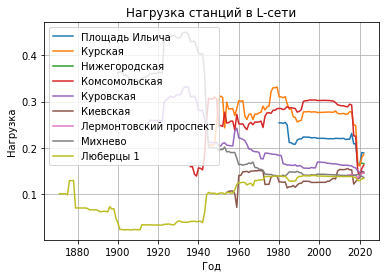

In [18]:
for nodes in stations_demo:
    for node in nodes:
        if node in df_l_stations_demo['Номер'].values:
            plt.plot(df_l_stations_demo[df_l_stations_demo['Номер'] == node]['Нагрузка'], label=stations_demo[nodes])
            break
    
plt.title('Нагрузка станций в L-сети')
plt.xlabel('Год')
plt.ylabel('Нагрузка')
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend()
plt.savefig('./results/stations_betweenness_centrality.png')
plt.grid()
plt.show()

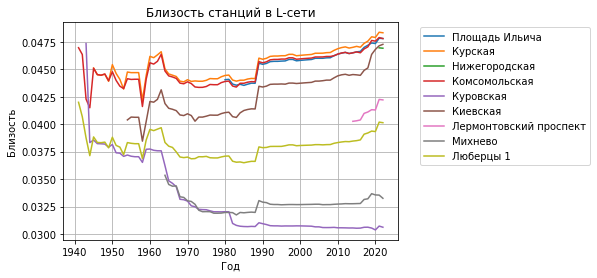

In [71]:
for nodes in stations_demo:
    for node in nodes:
        if node in df_l_stations_demo['Номер'].values:
            plt.plot(df_l_stations_demo[df_l_stations_demo['Номер'] == node]['Близость'], label=stations_demo[nodes])
            break

plt.title('Близость станций в L-сети')
plt.xlabel('Год')
plt.ylabel('Близость')
plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.legend()
plt.savefig('./results/stations_closeness_centrality.png')
plt.grid()
plt.show()

In [24]:
df_l_degree = pd.DataFrame(columns=['Линия','Станция', 'Степень'])
for node, degree in nx.degree(l_network22):
    pd_row = pd.DataFrame([[df_l_stations22.loc[df_l_stations22['row_number'] == node]['line'].values[0]
                            , df_l_stations22.loc[df_l_stations22['row_number'] == node]['station'].values[0]
                            , degree]],
                    columns=['Линия','Станция', 'Степень'])
    df_l_degree = df_l_degree.append(pd_row)
df_l_degree = df_l_degree.sort_values('Степень', ascending=False, ignore_index=True)
print(df_l_degree[:15])
print()

bc = nx.betweenness_centrality(l_network22)
df_l_betweenness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Нагрузка'])
for node in bc:
    pd_row = pd.DataFrame([[df_l_stations22.loc[df_l_stations22['row_number'] == node]['line'].values[0]
                            , df_l_stations22.loc[df_l_stations22['row_number'] == node]['station'].values[0]
                            , bc[node]]],
                    columns=['Линия','Станция', 'Нагрузка'])
    df_l_betweenness_centrality = df_l_betweenness_centrality.append(pd_row)
df_l_betweenness_centrality = df_l_betweenness_centrality.sort_values('Нагрузка', ascending=False, ignore_index=True)
print(df_l_betweenness_centrality[:15])  
print()

cc = nx.closeness_centrality(l_network22)
df_l_closeness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Близость'])
for node in cc:
    pd_row = pd.DataFrame([[df_l_stations22.loc[df_l_stations22['row_number'] == node]['line'].values[0]
                            , df_l_stations22.loc[df_l_stations22['row_number'] == node]['station'].values[0]
                            , cc[node]]],
                    columns=['Линия','Станция', 'Близость'])
    df_l_closeness_centrality = df_l_closeness_centrality.append(pd_row)
df_l_closeness_centrality = df_l_closeness_centrality.sort_values('Близость', ascending=False, ignore_index=True)
print(df_l_closeness_centrality[:15])  
print()

                        Линия                  Станция Степень
0         Арбатско-Покровская                 Киевская       8
1              Замоскворецкая               Войковская       8
2   Серпуховско-Тимирязевская              Нагатинская       7
3              Сокольническая            Комсомольская       7
4              Сокольническая  Библиотека имени Ленина       7
5                   Кольцевая                Таганская       6
6         Арбатско-Покровская               Кунцевская       6
7       Люблинско-Дмитровская                 Окружная       6
8         Арбатско-Покровская                  Курская       6
9   Серпуховско-Тимирязевская    Петровско-Разумовская       6
10             Замоскворецкая                 Тверская       6
11             Замоскворецкая              Белорусская       6
12         Некрасовская линия            Нижегородская       6
13                Калининская             Авиамоторная       6
14                Калининская           Площадь Ильича 

In [25]:
df_p_degree = pd.DataFrame(columns=['Линия','Станция', 'Степень'])
for node, degree in nx.degree(p_network22):
    pd_row = pd.DataFrame([[df_p_stations22.loc[df_p_stations22['row_number'] == node]['line'].values[0]
                            , df_p_stations22.loc[df_p_stations22['row_number'] == node]['station'].values[0]
                            , degree]],
                    columns=['Линия','Станция', 'Степень'])
    df_p_degree = df_p_degree.append(pd_row)
df_p_degree = df_p_degree.sort_values('Степень', ascending=False, ignore_index=True)
print(df_p_degree[:15])
print()
    
bc = nx.betweenness_centrality(p_network22)
df_p_betweenness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Нагрузка'])
for node in bc:
    pd_row = pd.DataFrame([[df_p_stations22.loc[df_p_stations22['row_number'] == node]['line'].values[0]
                            , df_p_stations22.loc[df_p_stations22['row_number'] == node]['station'].values[0]
                            , bc[node]]],
                    columns=['Линия','Станция', 'Нагрузка'])
    df_p_betweenness_centrality = df_p_betweenness_centrality.append(pd_row)
df_p_betweenness_centrality = df_p_betweenness_centrality.sort_values('Нагрузка', ascending=False, ignore_index=True)
print(df_p_betweenness_centrality[:15]) 
print()

cc = nx.closeness_centrality(p_network22)
df_p_closeness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Близость'])
for node in cc:
    pd_row = pd.DataFrame([[df_p_stations22.loc[df_p_stations22['row_number'] == node]['line'].values[0]
                            , df_p_stations22.loc[df_p_stations22['row_number'] == node]['station'].values[0]
                            , cc[node]]],
                    columns=['Линия','Станция', 'Близость'])
    df_p_closeness_centrality = df_p_closeness_centrality.append(pd_row)
df_p_closeness_centrality = df_p_closeness_centrality.sort_values('Близость', ascending=False, ignore_index=True)
print(df_p_closeness_centrality[:15])  
print()

                         Линия                 Станция Степень
0               Сокольническая           Комсомольская     305
1                  Горьковское                Чухлинка     172
2                  Казанское:2             Воскресенск     170
3                  Казанское:1               Куровская     158
4          Арбатско-Покровская                 Курская     156
5                Кольцевое/2:2                 Михнево     153
6                  Кольцевое/2                  142 км     151
7                Кольцевое/2:2                  165 км     150
8                 Киевское:2:2              Бекасово-1     148
9                  Кольцевое/2                    Икша     147
10            Калужско-Рижская                 Рижская     145
11           Горьковское:2:2:2           Орехово-Зуево     145
12                 Казанское:2                   88 км     145
13         Арбатско-Покровская        Электрозаводская     144
14  Таганско-Краснопресненская  Лермонтовский проспект 

In [26]:
df_l_degree.to_excel('./results/l_degree.xlsx')
df_l_betweenness_centrality.to_excel('./results/l_betweenness_centrality.xlsx')
df_l_closeness_centrality.to_excel('./results/l_closeness_centrality.xlsx')
df_p_degree.to_excel('./results/p_degree.xlsx')
df_p_betweenness_centrality.to_excel('./results/p_betweenness_centrality.xlsx')
df_p_closeness_centrality.to_excel('./results/p_closeness_centrality.xlsx')